In [99]:
import os
import torch.nn as nn
import torchvision.models as models
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch 
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import random

In [100]:
seed = 42 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [101]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [102]:
class SingleSampleDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_to_idx = {}
        self.idx_to_label = {}
        self.images_in_memory = []  # Store images in RAM

        # Collect image paths and corresponding labels
        for series in os.listdir(root_dir):
            series_path = os.path.join(root_dir, series)
            if os.path.isdir(series_path):
                for img_name in os.listdir(series_path):
                    if ".json" in img_name:
                        continue
                    img_path = os.path.join(series_path, img_name)
                    self.image_paths.append(img_path)
                    
                    label = img_name  
                    if label not in self.label_to_idx:
                        idx = len(self.label_to_idx)
                        self.label_to_idx[label] = idx
                        self.idx_to_label[idx] = label
                    
                    self.labels.append(self.label_to_idx[label])

                    # Load the image into memory
                    image = Image.open(img_path)
                    if image.mode != "RGB":
                        image = image.convert("RGB")
                    self.images_in_memory.append(image)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.images_in_memory[idx]
        label_idx = self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(label_idx), num_classes=len(self.label_to_idx))

        if self.transform:
            image = self.transform(image)

        return image, one_hot_label.float()
    

transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(1, 1),),
    transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.3, hue=0.05),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.96, 1.06)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SingleSampleDataset(root_dir='cards', transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)

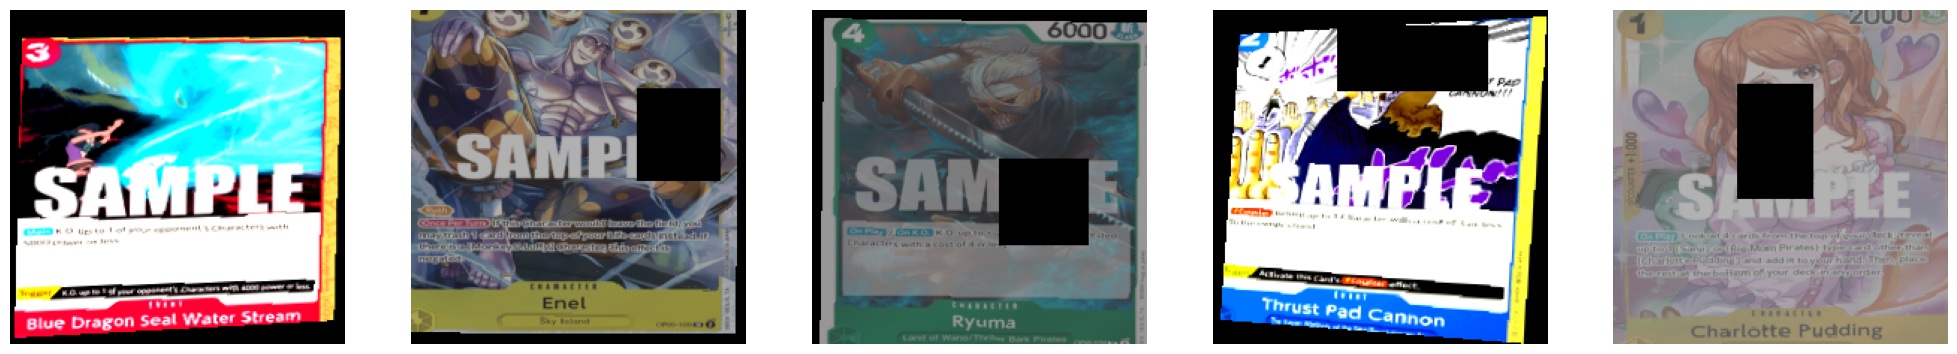

In [103]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# reverse normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

images = images * std[:, None, None] + mean[:, None, None]
images = images.numpy()
images = images.transpose((0, 2, 3, 1))
images = images[:5]
fig, axes = plt.subplots(1, len(images), figsize=(25, 25))
if len(images) == 1:
    axes = [axes]

for i, img in enumerate(images):
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

In [104]:
base_model = models.resnet50(pretrained=True)

# Freeze all layers
for param in base_model.parameters():
    param.requires_grad = False


# Get the number of features from the original fully connected layer
num_ftrs = base_model.fc.in_features
base_model.fc = nn.Identity()

embedding_size = 512

class CardModel(nn.Module):
    def __init__(self, base_model, embedding_size):
        super(CardModel, self).__init__()
        self.base_model = base_model
        self.embedding_layer = nn.Linear(num_ftrs, embedding_size)
        self.classification_layer = nn.Linear(embedding_size, len(dataset.labels))

    def forward(self, x):
        x = self.base_model(x)
        x = self.embedding_layer(x) 
        logits = self.classification_layer(x)
        return x, logits
        
model = CardModel(base_model, embedding_size).to(device)

/home/kono/.local/share/virtualenvs/tcg-scanner-gdmEvyDg/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kono/.local/share/virtualenvs/tcg-scanner-gdmEvyDg/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/kono/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


In [105]:
criterion = nn.CrossEntropyLoss()

def train_loop(num_epochs, optimizer):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, one_hot_labels in train_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)

            optimizer.zero_grad()
            
            embeddings, logits = model(inputs)
            
            labels = torch.argmax(one_hot_labels, dim=1)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.detach()
        
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')


In [106]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_loop(50, optimizer)

Epoch 1/50, Loss: 8.5717, Accuracy: 0.00%
Epoch 2/50, Loss: 9.1307, Accuracy: 0.00%
Epoch 3/50, Loss: 7.4672, Accuracy: 0.00%
Epoch 4/50, Loss: 7.1178, Accuracy: 0.29%
Epoch 5/50, Loss: 6.7353, Accuracy: 0.43%
Epoch 6/50, Loss: 6.2108, Accuracy: 2.36%
Epoch 7/50, Loss: 5.5857, Accuracy: 6.79%
Epoch 8/50, Loss: 5.0112, Accuracy: 11.72%
Epoch 9/50, Loss: 4.3250, Accuracy: 19.09%
Epoch 10/50, Loss: 3.6742, Accuracy: 28.31%
Epoch 11/50, Loss: 3.0878, Accuracy: 39.67%
Epoch 12/50, Loss: 2.5266, Accuracy: 49.54%
Epoch 13/50, Loss: 2.0339, Accuracy: 59.47%
Epoch 14/50, Loss: 1.7482, Accuracy: 65.05%
Epoch 15/50, Loss: 1.4775, Accuracy: 69.26%
Epoch 16/50, Loss: 1.2310, Accuracy: 74.77%
Epoch 17/50, Loss: 1.1411, Accuracy: 77.27%
Epoch 18/50, Loss: 1.0563, Accuracy: 77.06%
Epoch 19/50, Loss: 0.9237, Accuracy: 80.84%
Epoch 20/50, Loss: 0.7637, Accuracy: 83.70%
Epoch 21/50, Loss: 0.7717, Accuracy: 82.27%
Epoch 22/50, Loss: 0.7471, Accuracy: 83.27%
Epoch 23/50, Loss: 0.6306, Accuracy: 85.13%
Epoc

In [107]:
# Optionally, unfreeze more layers and fine-tune with a lower learning rate
for param in model.base_model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
train_loop(25, optimizer)

Epoch 1/25, Loss: 0.2568, Accuracy: 93.35%
Epoch 2/25, Loss: 0.2188, Accuracy: 94.21%
Epoch 3/25, Loss: 0.1262, Accuracy: 96.43%
Epoch 4/25, Loss: 0.1289, Accuracy: 96.35%
Epoch 5/25, Loss: 0.1097, Accuracy: 97.07%
Epoch 6/25, Loss: 0.1070, Accuracy: 97.14%
Epoch 7/25, Loss: 0.0952, Accuracy: 97.43%
Epoch 8/25, Loss: 0.0711, Accuracy: 98.00%
Epoch 9/25, Loss: 0.0562, Accuracy: 98.64%
Epoch 10/25, Loss: 0.0701, Accuracy: 98.00%
Epoch 11/25, Loss: 0.0712, Accuracy: 98.00%
Epoch 12/25, Loss: 0.0512, Accuracy: 98.64%
Epoch 13/25, Loss: 0.0510, Accuracy: 98.36%
Epoch 14/25, Loss: 0.0787, Accuracy: 97.78%
Epoch 15/25, Loss: 0.0428, Accuracy: 98.64%
Epoch 16/25, Loss: 0.0558, Accuracy: 98.71%
Epoch 17/25, Loss: 0.0440, Accuracy: 98.64%
Epoch 18/25, Loss: 0.0414, Accuracy: 99.00%
Epoch 19/25, Loss: 0.0288, Accuracy: 99.07%
Epoch 20/25, Loss: 0.0342, Accuracy: 99.07%
Epoch 21/25, Loss: 0.0357, Accuracy: 99.07%
Epoch 22/25, Loss: 0.0493, Accuracy: 98.78%
Epoch 23/25, Loss: 0.0285, Accuracy: 99.2

In [108]:
torch.save(model.state_dict(), f'{time.time()}_model_state_dict.pth')
torch.save(model, f'{time.time()}_model_save.pth')

In [109]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, one_hot_labels in train_loader:
        labels = torch.argmax(one_hot_labels.to(device), dim=1)
        embeddings, logits = model(inputs.to(device))
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print(f'Accuracy: {100 * correct / total}%')

Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 99.6875%
Accuracy: 99.7159090909091%
Accuracy: 99.73958333333333%
Accuracy: 99.75961538461539%
Accuracy: 99.55357142857143%
Accuracy: 99.58333333333333%
Accuracy: 99.609375%
Accuracy: 99.63235294117646%
Accuracy: 99.65277777777777%
Accuracy: 99.67105263157895%
Accuracy: 99.53125%
Accuracy: 99.4047619047619%
Accuracy: 99.43181818181819%
Accuracy: 99.45652173913044%
Accuracy: 99.47916666666667%
Accuracy: 99.375%
Accuracy: 99.39903846153847%
Accuracy: 99.30555555555556%
Accuracy: 99.33035714285714%
Accuracy: 99.35344827586206%
Accuracy: 99.375%
Accuracy: 99.39516129032258%
Accuracy: 99.31640625%
Accuracy: 99.33712121212122%
Accuracy: 99.35661764705883%
Accuracy: 99.375%
Accuracy: 99.39236111111111%
Accuracy: 99.32432432432432%
Accuracy: 99.25986842105263%
Accuracy: 99.27884615384616%
Accuracy: 99.296875%
Accuracy: 99.31402439024

In [110]:
# preprocesing for forward pass
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet's mean and std
])

def extract_embedding(model, img_path):
    model.eval()
    image = Image.open(img_path)
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = transform(image)
    with torch.no_grad():
        embedding, logits = model(image.unsqueeze(0).to(device))
    return F.normalize(embedding, p=2, dim=1).cpu().numpy().flatten(), logits



In [111]:
import re
def extract_prefix(card_id):
    match = re.match(r'^[^-]+', card_id)
    return match.group(0) if match else ''

OP05-119.jpg


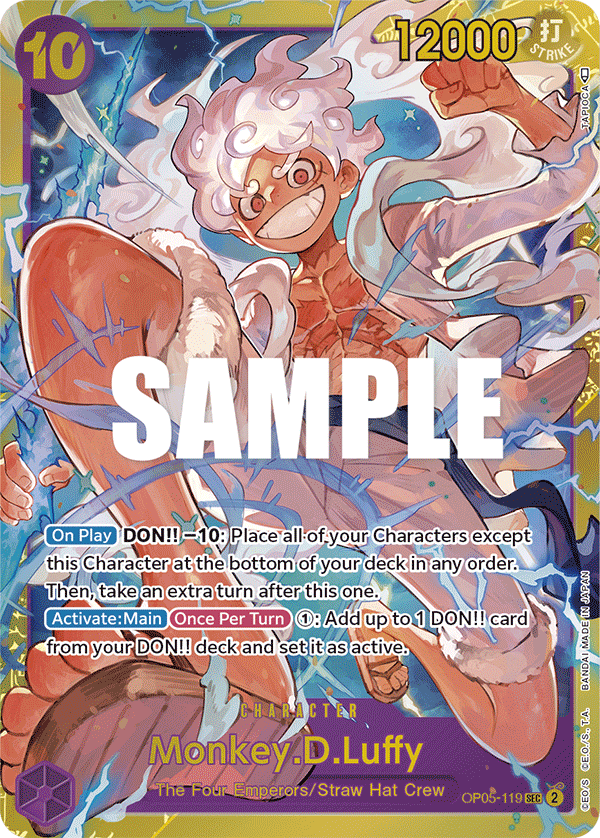

In [112]:
embedding, logits = extract_embedding(model, "monkey.png")

probabilities = F.softmax(logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1)

predicted_class = predicted_class.item()
predicted_class_name = dataset.idx_to_label[predicted_class]
print(predicted_class_name)
image = Image.open("cards/" +  extract_prefix(predicted_class_name) + "/" + predicted_class_name)
image

In [113]:
card_embeddings = []
root_dir = "cards"
index = 0
index_to_card_id = {}

for series in os.listdir(root_dir):
    series_path = os.path.join(root_dir, series)
    if os.path.isdir(series_path):
        for img_name in os.listdir(series_path):
            if ".json" in img_name:
                continue
            img_path = os.path.join(series_path, img_name)
            label = img_name  
            embedding, _ = extract_embedding(model, img_path)
            card_embeddings.append(embedding)
            index_to_card_id[index] = label
            index += 1

In [114]:
from sklearn.metrics.pairwise import euclidean_distances
from pathlib import Path

def find_image_path(card_id, root_dir="cards"):
    root_path = Path(root_dir)
    for image_path in root_path.rglob(f"{card_id}"):
        return image_path
    return None

card_embeddings_np = np.array(card_embeddings, dtype='float32')

# Define a query vector
query_embedding, _ = extract_embedding(model, "monkey.png") 
query_embedding = np.array([query_embedding]) 

distances = euclidean_distances(card_embeddings_np, query_embedding)

# Find the indices of the 5 closest vectors
top_k = 5
closest_indices = np.argsort(distances.flatten())[:top_k]

# Retrieve the closest card IDs
closest_card_ids = [index_to_card_id[idx] for idx in closest_indices]
closest_distances = [distances[idx][0] for idx in closest_indices]

Match 1:
Card ID: OP05-119.jpg
Distance: 0.6165542006492615


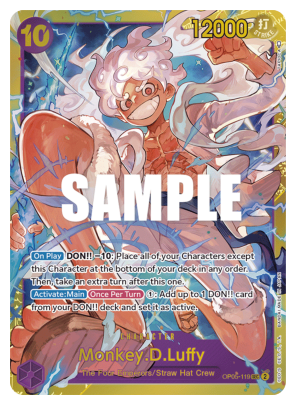

Match 2:
Card ID: OP04-019_p1.jpg
Distance: 0.8533164262771606


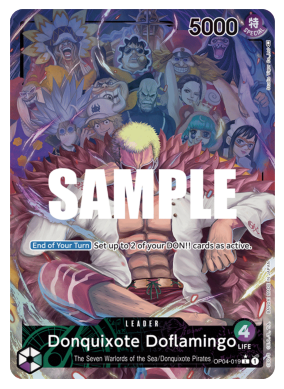

Match 3:
Card ID: OP01-024_p1.jpg
Distance: 0.8943315744400024


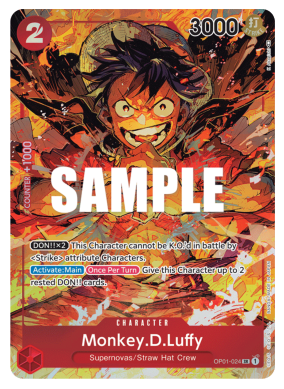

Match 4:
Card ID: ST01-012_p2.jpg
Distance: 0.9121163487434387


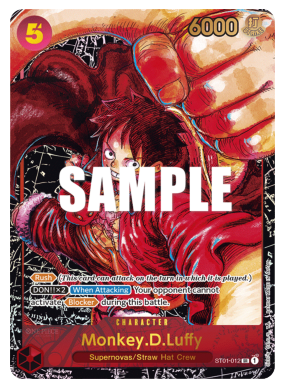

Match 5:
Card ID: OP06-069_p1.jpg
Distance: 0.9251429438591003


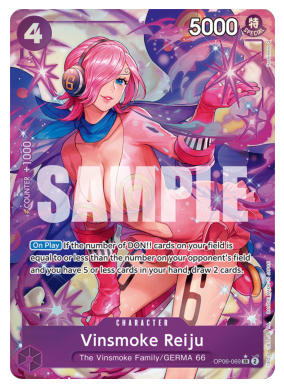

In [115]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
if top_k == 1:
    axes = [axes] 

for i, card_id in enumerate(closest_card_ids):
    image_path = find_image_path(card_id)
    if image_path:
        image = Image.open(image_path)
        print(f"Match {i + 1}:")
        print(f"Card ID: {card_id}")
        print(f"Distance: {closest_distances[i]}")
        plt.imshow(image)
        plt.axis('off')
        plt.show()